In [4]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import requests
import gmaps
import os
from api_keys import g_key

file_to_load = "../airbnb/AirBnB 2019/calendar_2019.csv"
list_to_load = "../airbnb/AirBnB 2019/listings_2019.csv"

cal_2019 = pd.read_csv(file_to_load)
list_2019 = pd.read_csv(list_to_load, low_memory = False)

file_to_load = "../airbnb/AirBnB 2020/calendar_2020.csv"
cal_2020 = pd.read_csv(file_to_load)

file_to_load = "../airbnb/AirBnB 2020/listings_2020.csv"
list_2020 = pd.read_csv(file_to_load)

In [5]:
list_2019 = list_2019[['id','name','host_response_time','host_response_rate','host_is_superhost',
                           'city','latitude','longitude','property_type','room_type',
                           'accommodates','bathrooms','bedrooms','beds', 'amenities','price',
                           'security_deposit', 'cleaning_fee', 'has_availability',
                           'availability_365', 'number_of_reviews','review_scores_rating',
                           'review_scores_accuracy', 'review_scores_cleanliness',
                           'review_scores_checkin', 'review_scores_communication',
                           'review_scores_location', 'review_scores_value','reviews_per_month']]
list_2019 = list_2019.rename(columns = {'id': 'listing_id'})

In [6]:
list_2020 = list_2020[['id','name','host_response_time','host_response_rate','host_is_superhost',
                       'neighbourhood_cleansed',
                       'latitude','longitude','property_type','room_type',
                       'accommodates','bathrooms','bedrooms','beds', 'amenities','price', 'has_availability',
                       'availability_365', 'number_of_reviews','review_scores_rating',
                       'review_scores_accuracy', 'review_scores_cleanliness',
                       'review_scores_checkin', 'review_scores_communication',
                       'review_scores_location', 'review_scores_value','reviews_per_month']]
list_2020 = list_2020.rename(columns = {'id': 'listing_id','neighbourhood_cleansed':'city'})

In [7]:
neighborhood_count19 = pd.DataFrame(list_2019['city'].value_counts())
neighborhood_count20 = pd.DataFrame(list_2020['city'].value_counts())
neighborhood_count20 = pd.merge(neighborhood_count19, neighborhood_count20, left_index = True, right_index = True, how = 'outer', suffixes = ('_2019','_2020'))
neighborhood_count20 = neighborhood_count20.sort_values(by = 'city_2019', ascending = False)
neighborhood_count20 = neighborhood_count20.rename(columns = {'city_2019': '2019 Listings', 'city_2020': '2020 Listings'})
neighborhood_count20['Change in Listings'] = neighborhood_count20['2020 Listings'] - neighborhood_count20['2019 Listings']
neighborhood_count20.head()

,2019 Listings,2020 Listings,Change in Listings
Melbourne,7368,6174,-1194
Port Phillip,2808,2498,-310
Yarra,2049,1578,-471
Stonnington,1621,1369,-252
Moreland,967,863,-104


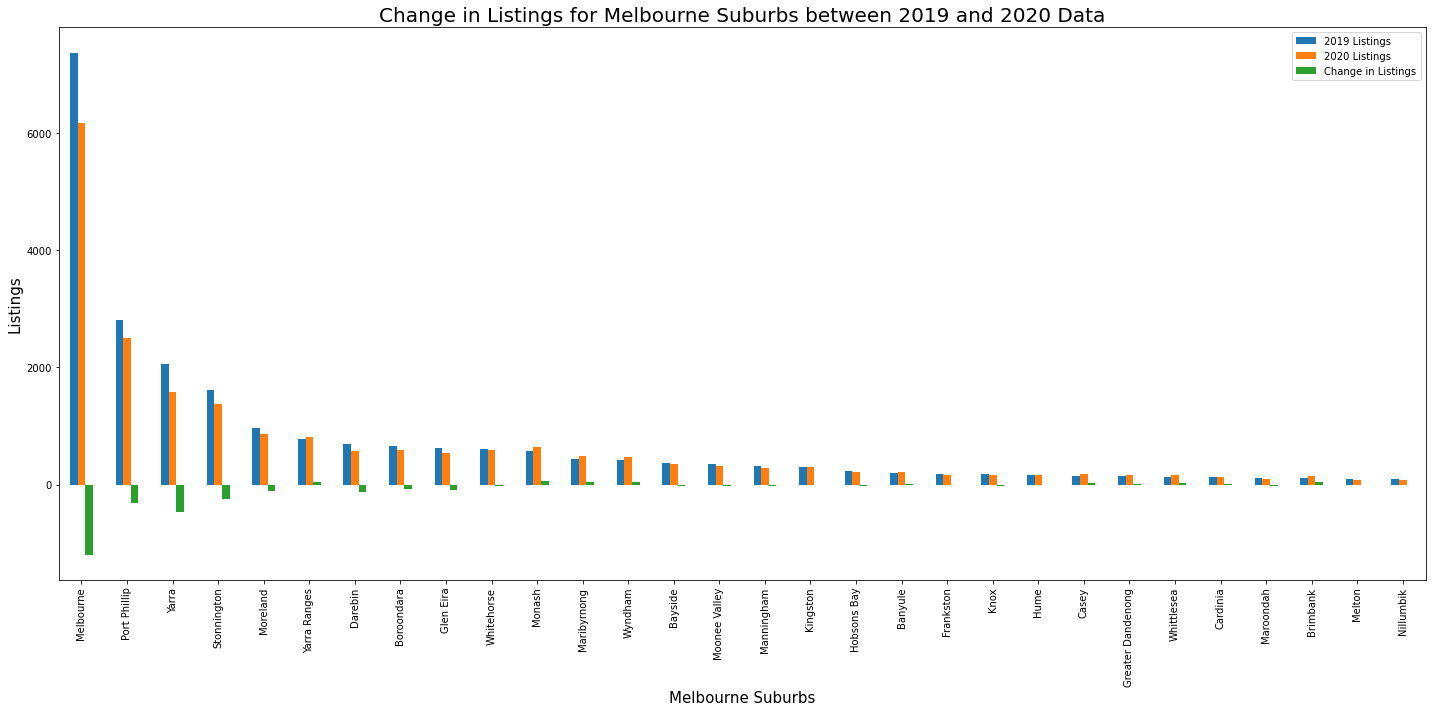

In [8]:
neighborhood_count20.plot(kind = 'bar', y = ['2019 Listings', '2020 Listings', 'Change in Listings'], 
                          align = 'center', figsize = (20,10))
plt.xlabel('Melbourne Suburbs', fontsize = 15)
plt.ylabel('Listings', fontsize = 15)
plt.title('Change in Listings for Melbourne Suburbs between 2019 and 2020 Data', fontsize = 20)
plt.tight_layout()
plt.savefig('listings_bar.png')

# Create below this, dataframe with room type count for each year, then map to bar chart as above showing any differences between 2019 and 2020

# Comparing Days Booked Across Cities

## Of interest here is that Moreland is the highest average days booked across all council areas in 2019.

In [54]:
list_2019['Booked_2019'] = 365 - list_2019['availability_365']
neighborhood_book2019 = list_2019.groupby('city').mean()
total_days = pd.DataFrame(neighborhood_book2019['Booked_2019'])
neighborhood_book2019 = list_2019.groupby('city').median()
total_days['Median Days Booked 2019'] = neighborhood_book2019['Booked_2019']



list_2020['Booked_2020'] = 365 - list_2020['availability_365']
neighborhood_book20 = list_2020.groupby('city').mean()
total_days20 = pd.DataFrame(neighborhood_book20['Booked_2020'])
neighborhood_book20 = list_2020.groupby('city').median()
total_days20['Median Days Booked 2020'] = neighborhood_book20['Booked_2020']
total_days = pd.DataFrame(pd.merge(total_days, total_days20, left_index = True, right_index = True, how = 'outer'))
total_days = total_days.sort_values(by = 'Booked_2019', ascending = False)
total_days = total_days.rename(columns = {'Booked_2019': 'Average Days Booked 2019','Booked_2020':'Average Days Booked 2020'})
total_days = total_days.reset_index(inplace = False)
total_days.head()

,city,Average Days Booked 2019,Median Days Booked 2019,Average Days Booked 2020,Median Days Booked 2020
0,Moreland,265.514995,320.0,252.209733,287.0
1,Yarra,265.232796,327.0,253.365019,341.0
2,Darebin,259.992837,323.0,256.111111,333.0
3,Melbourne,242.376629,289.0,231.425656,275.0
4,Stonnington,239.495373,294.0,235.598977,278.0


In [9]:
cal_2019['date'] = pd.to_datetime(cal_2019['date'])
cal_2019['day'] = cal_2019['date'].dt.day
cal_2019['month'] = cal_2019['date'].dt.month
cal_2019['year'] = cal_2019['date'].dt.year

In [10]:
cal_2020['date'] = pd.to_datetime(cal_2020['date'])
cal_2020['day'] = cal_2020['date'].dt.day
cal_2020['month'] = cal_2020['date'].dt.month
cal_2020['year'] = cal_2020['date'].dt.year

In [27]:
sub_cal_2019 = pd.merge(cal_2019[['listing_id','date','available','day','month','year']],
                        list_2019[['listing_id','city']], on = 'listing_id',how = 'outer')
sub_cal_2019 = sub_cal_2019.loc[sub_cal_2019['available'] == 'f']
sub_cal_2019.head()

,listing_id,date,available,day,month,year,city
0,136510,2019-10-15,f,15,10,2019,Melbourne
1,136510,2019-10-14,f,14,10,2019,Melbourne
2,136510,2019-10-13,f,13,10,2019,Melbourne
3,136510,2019-10-12,f,12,10,2019,Melbourne
4,136510,2019-10-11,f,11,10,2019,Melbourne


In [ ]:
sub_cal_2020 = pd.merge(cal_2020[['listing_id','date','available','day','month','year']],
                        list_2020[['listing_id','city']], on = 'listing_id',how = 'outer')
sub_cal_2020 = sub_cal_2020.loc[sub_cal_2020['available'] == 'f']
sub_cal_2020.head()

# Heatmap of locations in 2019 for nightly price

In [61]:
gmaps.configure(api_key=g_key)
fig2019 = gmaps.figure()
coord2019 = list_2019[['latitude','longitude']]
price = list_2019['price']
heat_layer = gmaps.heatmap_layer(coord2019, weights = price, dissipating = False, max_intensity = max(price), point_radius=0.009)
fig2019.add_layer(heat_layer)
fig2019

Figure(layout=FigureLayout(height='420px'))

# Heatmap of locations in 2020 for nightly price

## Use Sherin's code to remove the dollar sign from the price per night column

list_2020['price'] = list_2020['price'].replace('[\$,]', '', regex=True).astype(float)

In [60]:
gmaps.configure(api_key=g_key)
fig2020 = gmaps.figure()
coord2020 = list_2020[['latitude','longitude']]
list_2020['price'] = list_2020['price'].replace('[\$,]', '', regex=True).astype(float)
price = list_2020['price']
heat_layer = gmaps.heatmap_layer(coord2020, weights = price, dissipating = False, max_intensity = max(price), point_radius=0.009)
fig2020.add_layer(heat_layer)
fig2020

Figure(layout=FigureLayout(height='420px'))

# Look at the top 5 suburbs for average days booked and look for trends in their busy months

In [73]:
months = list(sub_cal_2019['month'].unique())
years = list(sub_cal_2019['year'].unique())
cities = list(total_days['city'].head(5))

rows_list = []
for city in cities:
    for year in years:
        for month in months:
            city_dict = {}
            df_city = sub_cal_2019.loc[(sub_cal_2019['city'] == city) & 
                                       (sub_cal_2019['available'] == 'f') & 
                                       (sub_cal_2019['month']==month) & 
                                       (sub_cal_2019['year']==year)]
            list_count = df_city['listing_id'].nunique()
            book_nights = df_city['day'].count()
            
            if list_count > 0:
                book_ave = round(book_nights/list_count,2)
                city_dict['City'] = city
                city_dict['Year'] = year
                city_dict['Month'] = month
                city_dict['Listings Available'] = list_count
                city_dict['Total of Nightly Bookings'] = book_nights
                city_dict['Average Nights Booked at Listing'] = book_ave
                rows_list.append(city_dict)
                
busy_month = pd.DataFrame(rows_list)
busy_month19 = busy_month.sort_values(['Year','Month'],ascending = True)
busy_month19.head()

,City,Year,Month,Listings Available,Total of Nightly Bookings,Average Nights Booked at Listing,Percentage Booked %
12,Moreland,2018,12,942,17516,18.59,5.0
25,Yarra,2018,12,2008,39544,19.69,5.0
38,Darebin,2018,12,664,13389,20.16,6.0
51,Melbourne,2018,12,7166,123712,17.26,5.0
64,Stonnington,2018,12,1574,28456,18.08,5.0


In [72]:
months = list(cal_2020['month'].unique())
years = list(cal_2020['year'].unique())
cities = list(total_days['city'].head(5))

rows_list = []
for city in cities:
    for year in years:
        for month in months:
            city_dict = {}
            df_city = sub_cal_2020.loc[(sub_cal_2020['city'] == city) & 
                                       (sub_cal_2020['available'] == 'f') & 
                                       (sub_cal_2020['month']==month) & 
                                       (sub_cal_2020['year']==year)]
        
            list_count = df_city['listing_id'].nunique()
            book_nights = df_city['day'].count()
            
            if list_count > 0:
                book_ave = round(book_nights/list_count,2)
                city_dict['City'] = city
                city_dict['Year'] = year
                city_dict['Month'] = month
                city_dict['Listings Available'] = list_count
                city_dict['Total of Nightly Bookings'] = book_nights
                city_dict['Average Nights Booked at Listing'] = book_ave
                rows_list.append(city_dict)
busy_month = pd.DataFrame(rows_list)

busy_month20 = busy_month.sort_values(['Year','Month'],ascending = True)
busy_month20.head()

C:\Users\cjdan\anaconda3\envs\OythonData\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


,City,Year,Month,Listings Available,Total of Nightly Bookings,Average Nights Booked at Listing,Percentage Booked %
0,Moreland,2020,8,745,7003,9.40,3.0
13,Yarra,2020,8,1327,12958,9.76,3.0
26,Darebin,2020,8,491,4749,9.67,3.0
39,Melbourne,2020,8,4801,45216,9.42,3.0
52,Stonnington,2020,8,1119,10239,9.15,3.0


In [ ]:
df_month = cal_2020.loc[(cal_2020['month']==9)]
df_month['listing_id'].nunique()

In [ ]:
days_cost = pd.merge(cal_2019, list_2019_price, on = 'listing_id', how = 'left')
daily_price_2019 = days_cost.groupby('listing_id').mean()
daily_price_2019.describe()

In [ ]:
#Finding all available booking ID's and total days available
avail_2019 = cal_2019.loc[cal_2018['available'] == 't']
avail_2019 = avail_2019.groupby('listing_id').count()
avail_2019 = pd.merge(avail_2019, list_2019_price, on = 'listing_id', how = 'left')
avail_2019 = avail_2019.rename(columns = {'available':'Number of Days Available',
                                          'price_y': 'Price per Night'})
avail_2019 = avail_2019[['listing_id','Number of Days Available','Price per Night']]
avail_2019

In [ ]:
#Finding all booked listing_id's and number of days booked
booked_2019 = cal_2019.loc[cal_2019['available'] == 'f']
booked_2019 = booked_2019.groupby('listing_id').count()
booked_2019 = pd.merge(booked_2019, list_2019_price, on = 'listing_id', how = 'left')
booked_2019 = booked_2019.rename(columns = {'available':'Number of Days Booked',
                                          'price_y': 'Price per Night'})
booked_2019 = booked_2019[['listing_id','Number of Days Booked','Price per Night']]
booked_2019

In [ ]:
cal_group = days_cost.groupby(['listing_id','available']).count()

cal_group

In [ ]:
cal_2019['date'] = pd.to_datetime(cal_2019['date'])
cal_2019.info()

In [ ]:
cal_2019['day'] = cal_2019['date'].dt.day
cal_2019['month'] = cal_2019['date'].dt.month
cal_2019['year'] = cal_2019['date'].dt.year

In [ ]:
month_2019 = cal_2019.groupby(['year','month']).count()
month_2019